# Learn PPCA

In [269]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np

### Load the data from the Markdown

In [270]:
data = io.loadmat('tonnage.mat')

In [271]:
X = data['X']
y = data['y'][:,0]
np.moveaxis(X,0,1).shape

(4, 1201, 582)

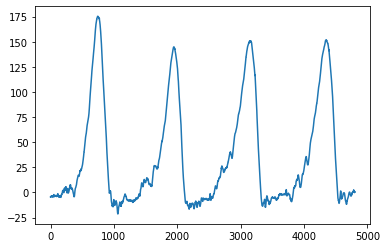

In [272]:
vx = np.moveaxis(X,0,1).reshape(-1,582).T
y[y==5]=2
plt.plot(vx[0,:])


In [273]:
from sklearn.decomposition import PCA
modelall = [[] for i in range(5)]
Wall = [[] for i in range(5)]
sigmaall = np.zeros(5)
ncomponents = [15,10,10,10,10]
for i in range(5):
    modelall[i] = PCA(svd_solver='auto', n_components=ncomponents[i])
    modelall[i].fit(vx[y==i])
    Wall[i] = modelall[i].components_.T
    sigmaall[i] = np.sqrt(modelall[i].noise_variance_)
    print(np.sum(modelall[i].explained_variance_ratio_))

0.8628242930092929
0.8680000763585767
0.8562988997801196
0.8404787894538558
0.8671274721564305


In [274]:
def fast_logdet(A):
    """Compute log(det(A)) for A symmetric
    Equivalent to : np.log(nl.det(A)) but more robust.
    It returns -Inf if det(A) is non positive or is not defined.
    Parameters
    ----------
    A : array_like
        The matrix
    """
    sign, ld = np.linalg.slogdet(A)
    if not sign > 0:
        return -np.inf
    return ld


### Solution of PCA is given by
PCA solution is given by
$$X = U S V^T$$ where $V$ is the loading matrix (pca.component.T). 
The PPCA solution is givne by 
$$W = V(L-\sigma^2I)^{1/2}.$$
$L$ is diagonal matrix with eigen values of Sample covariance and $\sigma$ is the noise;

see book  [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (12.45)

In [275]:
WPPCAall = [[] for i in range(5)]
for i in range(5):
    exp_var = modelall[i].explained_variance_
    exp_var_diff = np.maximum(exp_var - modelall[i].noise_variance_, 0.)
    WPPCAall[i]=modelall[i].components_.T.dot(np.diag(np.sqrt(exp_var_diff)))

Use [matrix inverse lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to compute the inverse of $$C^{-1} = (WW' + \sigma^2 I)^{-1} = \sigma^{-2} I -  \sigma^{-2} W ( W'W + \sigma^{2}I)^{-1} W'  $$
see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.40)

In [276]:
def get_precision(W,sigma):
    p = W.shape[0]
    n = W.shape[1]
    M = W.T@W + sigma**2*np.eye(n)
    precision = 1/sigma**2 * np.eye(p)- 1/sigma**2*W@np.linalg.solve(M,W.T)
    return precision

In [277]:
precision = [[] for i in range(5)]
for i in range(5):
    precision[i] = get_precision(WPPCAall[i],sigmaall[i])


see book [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) Eq. (12.44)

In [279]:
def loglk(X,mean,precision):
    log_like = 0
    Xr = X - mean
    p = len(mean)
    log_like = -.5 * (Xr * (np.dot(Xr, precision))).sum(axis=1)
    log_like -= .5 * (p * np.log(2. * np.pi) -
                      fast_logdet(precision))

    return log_like

Select columns from $W$

In [249]:
def create_sensing_matrix(p,index):
    p_obs = len(index);
    Z = np.zeros((p,p_obs));
    for ii,i in enumerate(index):
        Z[i,ii] = 1
    return Z


In [258]:
modelall[i].mean_.shape

(4804,)

In [280]:
pa = len(index)
r = np.zeros((582,4))
isample = 1
y = vx[isample,:].reshape(-1,1)
lrt = np.zeros(5)
for i in range(5):
    precision = get_precision(WPPCAall[i],sigmaall[i])
    lrt[i] = np.mean(loglk(y,modelall[i].mean_,precision))
    
print(lrt)

[-797962.8718885  -334891.53361976 -296131.0245605  -295614.17045221
 -320420.64864636]


In [281]:
for i in range(5):
    print(modelall[i].score(y.reshape(-1,1)))

-793549.2101135135
-330477.8718447746
-291717.3627855164
-291200.50867723045
-316006.98687137564


### Created Selected Sampling in index matrix

In [224]:
xchoice0 = np.random.choice(np.where(y==0)[0], size=100, replace=True)
xchoice4 = np.random.choice(np.where(y==4)[0], size=100, replace=True)
sampleindex = np.concatenate((xchoice0,xchoice4))

In [225]:
index = np.arange(0,4804,10)
index
pa = len(index)
A = create_sensing_matrix(4804,index)
r = np.zeros((582,4))
LRT = np.zeros((582,4))
for ii,isample in enumerate(sampleindex):
    xi = vx[isample,:]
    lrt = np.zeros(5)
    for i in range(5):
        Wa = (A.T@WPPCAall[i])
        precision = get_precision(Wa,sigmaall[i])
        mean = modelall[i].mean_[index]
        xa = (A.T@xi.T).reshape(1,pa)
        lrt[i] = np.mean(loglk(xa,mean,precision))
    LRT[ii] = np.cumsum(np.diff(lrt,1))
    r[ii] = np.log1p(np.exp(r[ii-1]))+LRT[ii]
    


In [283]:
isample = 300
xi = vx[isample,:]
lrt = np.zeros(5)
for i in range(5):
    Wa = (A.T@WPPCAall[i])
    precision = get_precision(Wa,sigmaall[i])
    mean = modelall[i].mean_[index]
    xa = (A.T@xi.T).reshape(1,pa)
    lrt[i] = np.mean(loglk(xa,mean,precision))


In [286]:
WPPCAall[i].shape

(4804, 10)

In [223]:
modelall[3].score(vx[400,:].reshape(1,-1))

-11533.350799760672